In [1]:
import os
import os.path as op
import nibabel as nib
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw, ImageFont, ImageEnhance
import imageio.v3 as imageio
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from tqdm import tqdm
import h5py
import pickle
os.chdir("../")

/export/raid1/home/kneel027/miniconda3/envs/SS/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/export/raid1/home/kneel027/miniconda3/envs/SS/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/export/raid1/home/kneel027/miniconda3/envs/SS/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [32]:
def condition_average(x, y, cond, nest=False):
    idx, idx_count = np.unique(cond, return_counts=True)
    idx_list = [np.array(cond)==i for i in np.sort(idx)]
    if nest:
        avg_x = torch.zeros((len(idx), idx_count.max(), x.shape[1]), dtype=torch.float32)
    else:
        avg_x = torch.zeros((len(idx), 1, x.shape[1]), dtype=torch.float32)
    arranged_y = torch.zeros((len(idx)), y.shape[1], y.shape[2], y.shape[3])
    for i, m in enumerate(idx_list):
        if nest:
            if np.sum(m) == idx_count.max():
                avg_x[i] = x[m]
            else:
                avg_x[i,:np.sum(m)] = x[m]
        else:
            avg_x[i] = torch.mean(x[m], axis=0)
        arranged_y[i] = y[m[0]]

    return avg_x, y, len(idx_count)

#subject: subject index between 1-3, or the subject identifier: CO, LF, TN
#mode: vision, imagery
#mask: True or False, if true masks the betas to visual cortex, otherwise returns the whole scanned region
#image_type: stimuli, cue
    # - stimuli will return the images with content that was either seen or imagined, this is what was presented to the subject in vision trials
    # - cue will return only the background images with the cue and no content, this is what was presented to the subject in imagery trials
#average: whether to average across trials, will produce x that is (stimuli, 1, voxels)
#nest: whether to nest the data according to stimuli, will produce x that is (stimuli, trials, voxels)
    # WARNING: Not all stimuli have the same number of repeats, so the middle dimension for the trial repetitions will contain empty values for some stimuli, be sure to account for this when loading
def load_imageryrf(subject, mode, mask=True, image_type="stimuli", average=False, nest=False):
    # This file has a bunch of information about the stimuli and cue associations that will make loading it easier
    img_conditional_file = "imageryrf_single_trial/stimuli/imageryrf_conditions.pkl3"
    ex_file = open(img_conditional_file, 'rb')
    conditional_dict = pickle.load(ex_file)
    ex_file.close()
    if isinstance(subject, int):
        subject = ["CO","LF","TN"][subject-1] 
    subject_cond = conditional_dict[subject]
    # Indicates what experiments trials belong to
    exps = subject_cond['experiment_cond']
    # Maps the cues to the stimulus image information
    image_map  = subject_cond['stimuli_cond'].to(int)
    # Organize the indices of the trials according to the modality and the type of stimuli
    cond_idx = {
    'vision': np.arange(len(exps))[np.char.find(exps, 'pcp') != -1],
    'imagery': np.arange(len(exps))[np.char.find(exps, 'img') != -1]}
    # Load normalized betas
    if mask:
        x = torch.load(f"imageryrf_single_trial/{subject}/single_trial_betas_masked.pt").requires_grad_(False).to("cpu")
    else:
        x = torch.load(f"imageryrf_single_trial/{subject}/single_trial_betas.pt").requires_grad_(False).to("cpu")
    # Find the stimuli indices conditioned on the mode of trials we want to load
    conditionals = image_map[cond_idx[mode]]
    # Stimuli file is of shape (18,3,425,425), these can be converted back into PIL images using transforms.ToPILImage()
    y = torch.load(f"imageryrf_single_trial/stimuli/{image_type}_images.pt").requires_grad_(False).to("cpu")
    # Prune the beta file down to specific experimental mode/stimuli type
    x = x[cond_idx[mode]]
    # Average or nest the betas across trials
    if average or nest:
        x, y, sample_count = condition_average(x, y, conditionals, nest=nest)
    else:
        x = x.reshape((x.shape[0], 1, x.shape[1]))
        y = y[conditionals]

    print(x.shape, y.shape)
    return x, y

In [35]:
for subject in tqdm(range(1,4)):
    x, y = load_imageryrf(subject=subject, mode="vision", mask=False, image_type="stimuli", average=False, nest=False)

  0%|          | 0/3 [00:00<?, ?it/s]

torch.Size([1792, 1, 349839]) torch.Size([1792, 3, 600, 600])


 33%|███▎      | 1/3 [00:03<00:07,  3.82s/it]

torch.Size([2048, 1, 347032]) torch.Size([2048, 3, 600, 600])


 67%|██████▋   | 2/3 [00:08<00:04,  4.14s/it]

torch.Size([1664, 1, 399430]) torch.Size([1664, 3, 600, 600])


100%|██████████| 3/3 [00:12<00:00,  4.12s/it]


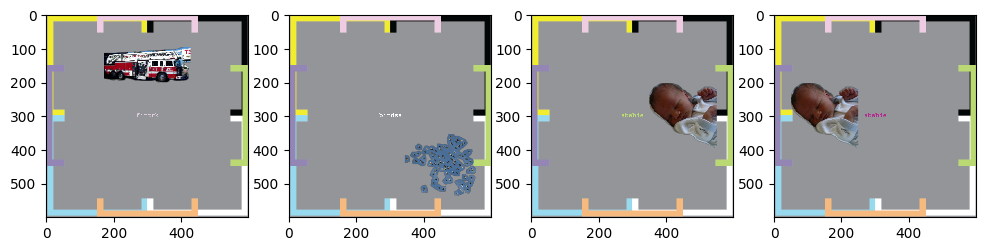

In [28]:

fig = plt.figure(figsize=(12,6))
for condn_indx in range(4):
    axs = fig.add_subplot(1,4, condn_indx+1)
    im=transforms.ToPILImage()(y[condn_indx])
    axs.imshow(im,cmap='gray', interpolation='None')